In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline



### Some facts about the data



In [66]:
train_df = pd.read_csv("../data/verkehrsunfaelle_train.csv").drop(['Unnamed: 0'],axis=1)
test_df = pd.read_csv("../data/verkehrsunfaelle_test.csv").drop(['Unnamed: 0'],axis=1)

print("train_df shape: " + str(train_df.shape))
print("test_df shape: " + str(test_df.shape))

train_df shape: (15221, 13)
test_df shape: (1000, 12)


In [67]:
train_df.head()

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
0,Bundesstrasse,23. Jan.,59,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,2,trocken,männlich,1330,LKW ab 7.5t,Gut
1,Autobahn,17-May-11,48,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,4,trocken,weiblich,1724,Auto,Gut
2,nicht klassifiziert,14. Feb.,56,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,1,1,nass / feucht,männlich,1345,Mottorrad (500cc),Gut
3,Bundesstrasse,31-Oct-12,66,Fahrer,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,3,2,nass / feucht,weiblich,1830,Auto,Regen
4,Bundesstrasse,3. Nov.,33,Fahrer,2,Dunkelheit: keine Strassenbeleuchtung,1,1,nass / feucht,männlich,15,Auto,Gut


In [69]:
test_df.head()

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
0,Bundesstrasse,8. Dez.,37,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,2,2,nass / feucht,weiblich,1100,Auto,Gut
1,Bundesstrasse,29-May-10,43,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,3,2,nass / feucht,männlich,1710,Auto,Gut
2,nicht klassifiziert,04-Mar-09,63,Passagier,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,1500,Bus,Gut
3,nicht klassifiziert,11-May-09,13,Fussgänger,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,männlich,1745,Auto,Gut
4,Bundesstrasse,5. Apr.,29,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,1900,Auto,Gut


<br>
Let's plot the target variable ('Unfallschwere') according to their occurences
<br>

/Users/christianklat/code_competition/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


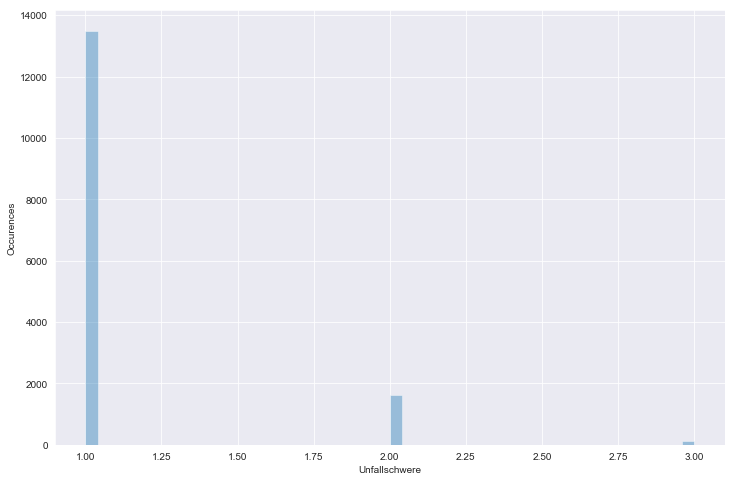

In [63]:
unfaelle = train_df["Unfallschwere"].values

plt.figure(figsize=(12, 8))
sns.distplot(unfaelle, kde=False)
plt.xlabel('Unfallschwere')
plt.ylabel('Occurences')
plt.show()